## Testing for `hopsy` with random data

In [4]:
import hopsy
import numpy as np

In [8]:
# the polytope is defined as
#          P := {x : Ax <= b}
# thus we need to define A and b. these constraints form the simple box [0,1]^2.
A = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
b = np.array([[1], [1], [0], [0]]);

# next we define our target distribution as an isotropic Gaussian with mean 0 and
# identity covariance.
mu = np.zeros((2,1))
cov = np.identity(2)

model = hopsy.MultivariateGaussianModel(mu, cov)

# the complete problem is defined by the target distribution and the constrained domain,
# defined by the above mentioned inequality
problem = hopsy.Problem(A, b, model)

In [9]:
# the run object contains and constructs the markov chains. in the default case, the
# Run object will have a single chain using the Hit-and-Run proposal algorithm and is
# set to produce 10,000 samples.
run = hopsy.Run(problem)

# we finally sample
run.sample()

Academic license - for non-commercial use only - expires 2021-11-23
Using license file /opt/gurobi912/gurobi.lic


In [10]:
# from the run, we can now extract the produced data
data = run.data

# the states is a list of lists of numpy.ndarrays, which can be casted to a numpy.ndarray
# which then has the shape (m,n,d), where m is the number of chains, n the number of samples
# and d the dimenion
states  = data.states

Now we neend to plot 

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

The `states` variable is a **list** of arrays. 
Usint the `pandas` library we can make a `DataFrame` out of it. 

In [104]:
df_data = pd.DataFrame(np.concatenate(states))
df_data

,0,1
0,0.527353,0.882257
1,0.983544,0.895377
2,0.966116,0.957163
3,0.511486,0.989361
4,0.868993,0.870392
...,...,...
995,0.175812,0.310576
996,0.609898,0.302661
997,0.280251,0.934239
998,0.008388,0.689737


### Some visualizations 

<AxesSubplot:ylabel='Count'>

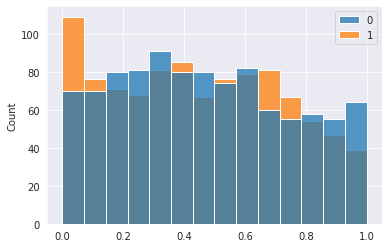

In [25]:
sns.set_style('darkgrid')
sns.histplot(df_data)


A better visualization. 

In [28]:
df_data = pd.DataFrame(np.concatenate(states), columns=['x', 'y'])
df_data

,x,y
0,0.527353,0.882257
1,0.983544,0.895377
2,0.966116,0.957163
3,0.511486,0.989361
4,0.868993,0.870392
...,...,...
995,0.175812,0.310576
996,0.609898,0.302661
997,0.280251,0.934239
998,0.008388,0.689737


In [52]:
x = df_data["x"]
y = df_data["y"]

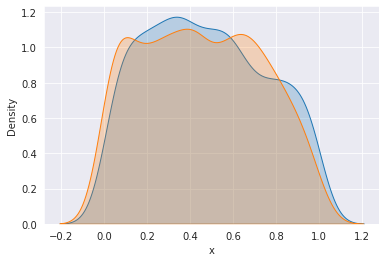

In [53]:
for col in 'xy':
    sns.kdeplot(df_data[col], shade=True)

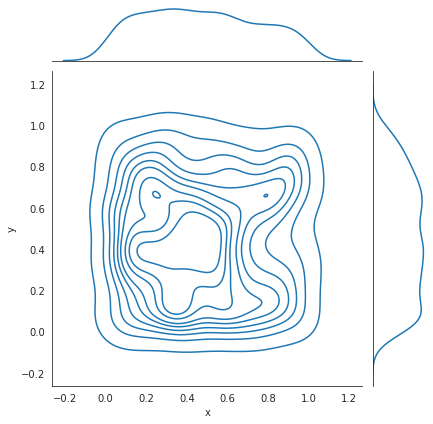

In [54]:
with sns.axes_style('white'):
    sns.jointplot(x=x, y=y, kind='kde');

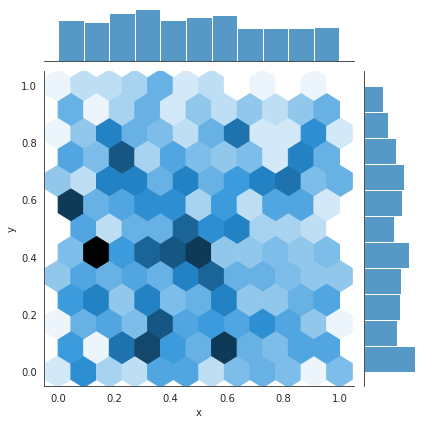

In [51]:
with sns.axes_style('white'):
    sns.jointplot(x=x, y=y, kind='hex')

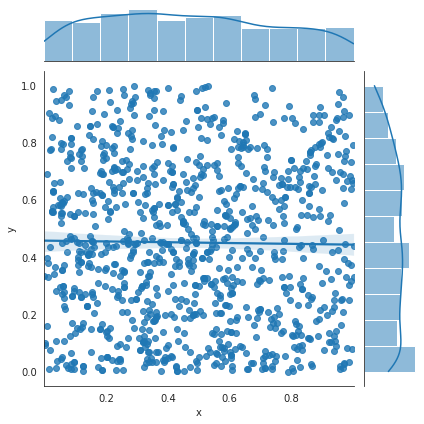

In [62]:
with sns.axes_style('white'):
    sns.jointplot(x=x, y=y, kind='reg')

## Testing for `PolyRound` using a BIGG model

In [90]:
import os
from PolyRound.api import PolyRoundApi
from PolyRound.static_classes.lp_utils import ChebyshevFinder
from PolyRound.settings import PolyRoundSettings
from pathlib import Path

In [65]:
model_path = "/home/haris/Desktop/polyround_SI/PolyRound/PolyRound/models/e_coli_core.xml"

In [66]:
model_path

'/home/haris/Desktop/polyround_SI/PolyRound/PolyRound/models/e_coli_core.xml'

In [70]:
# Create a settings object with the default settings.
settings = PolyRoundSettings()

In [72]:
settings.backend

'gurobi'

In [73]:
settings.check_lps

False

In [75]:
settings.hp_flags

{'FeasibilityTol': 1e-09, 'OptimalityTol': 1e-08}

In [76]:
settings.presolve

False

In [77]:
settings.reduce

True

In [78]:
# Import model and create Polytope object
polytope = PolyRoundApi.sbml_to_polytope(model_path)

In [148]:
polytope.A.shape

(190, 95)

In [149]:
polytope.S.shapepe

(72, 95)

In [101]:
# Remove redundant constraints and refunction inequality constraints that are de-facto equalities.
# Due to these inequalities, the polytope is empty (distance from chebyshev center to boundary is zero)
x, dist = ChebyshevFinder.chebyshev_center(polytope, settings)
print(dist)

[0.]


In [102]:
simplified_polytope = PolyRoundApi.simplify_polytope(polytope)

In [147]:
simplified_polytope.S.shape

(76, 95)

In [100]:
# The simplified polytope has non-zero border distance
x, dist = ChebyshevFinder.chebyshev_center(simplified_polytope, settings)
print(dist)

[0.58198972]


In [99]:
transformed_polytope = PolyRoundApi.transform_polytope(simplified_polytope)

In [95]:
# The distance from the chebyshev center to the boundary changes in the new coordinate system
x, dist = ChebyshevFinder.chebyshev_center(transformed_polytope, settings)
print(dist)

[1.00000001]


In [83]:
rounded_polytope = PolyRoundApi.round_polytope(transformed_polytope)

# After rounding, the distance from the chebyshev center to the boundary is set to be close to 1
x, dist = ChebyshevFinder.chebyshev_center(rounded_polytope, settings)
print(dist)

# The chebyshev center can be back transformed into an interior point in the simplified space.
print(simplified_polytope.border_distance(rounded_polytope.back_transform(x)))


[1.00000001]
0.03925295155234657


In [84]:
# simplify, transform and round in one call
one_step_rounded_polytope = PolyRoundApi.simplify_transform_and_round(polytope)

In [ ]:
'''
# Here are the features of the one_step_rounded_polytope object
# These features stand for any polytope object of the PolyRound

one_step_rounded_polytope.A
one_step_rounded_polytope.apply_shift
one_step_rounded_polytope.b
one_step_rounded_polytope.back_transform
one_step_rounded_polytope.border_distance
one_step_rounded_polytope.copy
one_step_rounded_polytope.h
one_step_rounded_polytope.inequality_only
one_step_rounded_polytope.normalize
one_step_rounded_polytope.normalize_system
one_step_rounded_polytope.remove_zero_rows
one_step_rounded_polytope.S
one_step_rounded_polytope.shift
one_step_rounded_polytope.transformation
'''

In [91]:
#save to hdf5
out_hdf5 = "/home/haris/Desktop/rounded_e_coli_core.hdf5"
PolyRoundApi.polytope_to_hdf5(one_step_rounded_polytope, out_hdf5)

#save to csv
out_csv_dir = "/home/haris/Desktop/testing_polyround_algo"
Path(out_csv_dir).mkdir(parents=True, exist_ok=True)
PolyRoundApi.polytope_to_csvs(one_step_rounded_polytope, out_csv_dir)


In [92]:
# Special use case: remove redundant constraints without removing zero facettes. This will leave th polytope with its original border distance.
x, dist = ChebyshevFinder.chebyshev_center(polytope, settings)
print(dist)
settings.simplify_only = True
simplified_polytope = PolyRoundApi.simplify_polytope(polytope, settings=settings)
# The simplified polytope still has zero border distance
x, dist = ChebyshevFinder.chebyshev_center(simplified_polytope, settings)
print(dist)


[0.]
[0.]


## Sampling using `hopsy` after rounding with `PolyRound`

In [121]:
one_step_rounded_polytope.A.shape

(36, 24)

In [122]:
one_step_rounded_polytope.b.shape

(36,)

In [106]:
problem = hopsy.Problem(one_step_rounded_polytope.A, one_step_rounded_polytope.b, model)

In [107]:
run = hopsy.Run(problem)
# we finally sample
run.sample()

In [108]:
data = run.data

# the states is a list of lists of numpy.ndarrays, which can be casted to a numpy.ndarray
# which then has the shape (m,n,d), where m is the number of chains, n the number of samples
# and d the dimenion
states  = data.states

In [157]:
print(type(states[0][0]))
print(states[0][0].shape)

<class 'numpy.ndarray'>
(24,)


We now need to map backwards the samples in the initial polytope... 